In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import tifffile
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
# Calculate distances between the union of k nearest neighbor effectors to targets, k nearest neighbor targets to effectors
def bidirectional_knn_distances(target_path, effector_path, output_folder, k=100):
    '''
    Parameters: target_spots path
                effector_spots path
                path to where the distance matrices is to be saved
                number of nearest neighbors to include
    
    Returns: pivoted distance master file
    '''
    # Load spots.csv files
    target_df = pd.read_csv(target_path)
    effector_df = pd.read_csv(effector_path)
    effector_df.drop([0,1,2], axis=0, inplace=True) # Remove duplicated column names in from TrackMate's output
    effector_df = effector_df.reset_index()

    # Cleanup data
    target_df['POSITION_X'] = pd.to_numeric(target_df['POSITION_X'], errors='coerce')
    target_df['POSITION_Y'] = pd.to_numeric(target_df['POSITION_Y'], errors='coerce')
    target_df['TRACK_ID'] = pd.to_numeric(target_df['TRACK_ID'], errors='coerce')
    target_df['FRAME'] = pd.to_numeric(target_df['FRAME'], errors='coerce')

    effector_df['POSITION_X'] = pd.to_numeric(effector_df['POSITION_X'], errors='coerce')
    effector_df['POSITION_Y'] = pd.to_numeric(effector_df['POSITION_Y'], errors='coerce')
    effector_df['TRACK_ID'] = pd.to_numeric(effector_df['TRACK_ID'], errors='coerce')
    effector_df['FRAME'] = pd.to_numeric(effector_df['FRAME'], errors='coerce')

    # Drop rows where conversion failed (i.e., invalid entries became NaN)
    target_df.dropna(subset=['POSITION_X', 'POSITION_Y', 'TRACK_ID', 'FRAME'], inplace=True)
    effector_df.dropna(subset=['POSITION_X', 'POSITION_Y', 'TRACK_ID', 'FRAME'], inplace=True)
    
    sample_idx = re.findall(r'xy(\d+)', output_folder) # for naming output files
    
    all_distances = []

    for frame in sorted(set(target_df['FRAME']).intersection(set(effector_df['FRAME']))):
        target_frame = target_df[target_df['FRAME'] == frame]
        effector_frame = effector_df[effector_df['FRAME'] == frame]

        target_coords = target_frame[['POSITION_X', 'POSITION_Y']].values
        effector_coords = effector_frame[['POSITION_X', 'POSITION_Y']].values
        target_ids = target_frame['TRACK_ID'].values
        effector_ids = effector_frame['TRACK_ID'].values

        if len(target_coords) == 0 or len(effector_coords) == 0:
            continue

        # Target to Effector
        nbrs_t2e = NearestNeighbors(n_neighbors=min(k, len(effector_coords))).fit(effector_coords)
        distances_t2e, indices_t2e = nbrs_t2e.kneighbors(target_coords)
        for i, (dists, idxs) in enumerate(zip(distances_t2e, indices_t2e)):
            for dist, idx in zip(dists, idxs):
                all_distances.append({
                    'Frame': frame,
                    'target_ID': target_ids[i],
                    'effector_ID': effector_ids[idx],
                    'Distance': dist
                })

        # Effector to Target
        nbrs_e2t = NearestNeighbors(n_neighbors=min(k, len(target_coords))).fit(target_coords)
        distances_e2t, indices_e2t = nbrs_e2t.kneighbors(effector_coords)
        for i, (dists, idxs) in enumerate(zip(distances_e2t, indices_e2t)):
            for dist, idx in zip(dists, idxs):
                all_distances.append({
                    'Frame': frame,
                    'target_ID': target_ids[idx],
                    'effector_ID': effector_ids[i],
                    'Distance': dist
                })

    # Combine and remove duplicates (if any)
    distance_df = pd.DataFrame(all_distances).drop_duplicates()
    # Pivot the DataFrame for ease of downstream analysis
    distance_pivot_df = distance_df.pivot_table(index=['target_ID', 'effector_ID'], columns='Frame', values='Distance')
    # Save the pivoted DataFrame for visualization
    distance_pivot_df.to_csv(os.path.join(output_folder, f'xy{sample_idx[-1]}_pivoted_distances.csv'))
    
    return distance_pivot_df

In [3]:
# Filter distance_pivot_df such that pairs where there is no NaN in N+1 consecutive frames is being retained
def has_valid_consecutive_values(row, N):
    # Convert to boolean mask: True where value is not NaN
    not_nan = row.notna().values.astype(int)
    
    # Use convolution to find stretches of N+1 consecutive non-NaNs
    window = np.ones(N + 1, dtype=int)
    valid_runs = np.convolve(not_nan, window, mode='valid')
    
    return np.any(valid_runs == (N + 1))

def filter_pairs_with_consecutive_non_nan(df, N):
    # Apply the check row-wise
    return df[df.apply(lambda row: has_valid_consecutive_values(row, N), axis=1)]

In [4]:
# Merge overlapping or consecutive (Start_Frame, End_Frame) intervals for the same (target_ID, effector_ID) pair.
def merge_overlapping_intervals(df):
    merged_rows = []

    # Group by target_ID and effector_ID
    for (target_id, effector_id), group in df.groupby(['target_ID', 'effector_ID']):
        # Sort intervals by Start_Frame
        intervals = group.sort_values('Start_Frame')[['Start_Frame', 'End_Frame']].values

        # Merge overlapping or consecutive intervals
        merged = []
        current_start, current_end = intervals[0]
        for start, end in intervals[1:]:
            if start <= current_end + 1:  # overlap or consecutive
                current_end = max(current_end, end)
            else:
                merged.append((target_id, effector_id, current_start, current_end))
                current_start, current_end = start, end
        merged.append((target_id, effector_id, current_start, current_end))  # final one

        merged_rows.extend(merged)

    return pd.DataFrame(merged_rows, columns=['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame'])

In [5]:
# Identify object pairs where the distance decreases over N consecutive frames
def find_approaching_pairs(distance_df, N, output_folder):
    '''
    Parameters: pivoted distance DataFrame, N number of consecutive frames, output folder path
    Returns: DataFrame with columns: target_ID, effector_ID, Start_Frame, End_Frame
    '''
    approaching_pairs = []    
    sample_idx = re.findall(r'xy(\d+)', output_folder) # for naming output files
    
    # Filter data
    filtered_pivot_df = filter_pairs_with_consecutive_non_nan(distance_df,N)
    
    # Loop through each pair
    for (obj1, obj2), distances in filtered_pivot_df.iterrows():
        frame_indices = distances.index
        # Check if the distance decreases over N consecutive frames
        for i in range(len(distances) - N):
            if all(distances[i] > distances[i + j + 1] for j in range(N)):
                approaching_pairs.append((obj1, obj2, distances.index[i], distances.index[i + N]))

    # Save results to CSV
    approaching_pairs_df = pd.DataFrame(approaching_pairs, columns = ['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame'])
    approaching_pairs_merged = merge_overlapping_intervals(approaching_pairs_df)
    approaching_pairs_merged.to_csv(os.path.join(output_folder, f'xy{sample_idx[-1]}_approaching_pairs.csv'), index=False)

    return approaching_pairs_df

In [6]:
# Identify object pairs where the distance stays below a threshold for N consecutive frames
def find_persistent_contact(distance_df, threshold, N, output_folder):
    '''
    Parameters: pivoted distance DataFrame, distance threshold, N number of consecutive frames, output folder path
    Returns: DataFrame with columns: target_ID, effector_ID, Start_Frame, End_Frame
    '''
    persistent_contact_pairs = []
    sample_idx = re.findall(r'xy(\d+)', output_folder) # for naming output files
    
    # Filter data
    filtered_pivot_df = filter_pairs_with_consecutive_non_nan(distance_df,N)
    
    # Loop through each pair
    for (obj1, obj2), distances in filtered_pivot_df.iterrows():
        frame_indices = distances.index
        # Check if the distance stays below the threshold for N consecutive frames
        for i in range(len(distances) - N):
            if all(distances[i + j] < threshold for j in range(N)):
                persistent_contact_pairs.append((obj1, obj2, distances.index[i], distances.index[i + N]))

    # Save results to CSV
    persistent_contact_pairs_df = pd.DataFrame(persistent_contact_pairs, columns = ['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame'])
    persistent_contact_pairs_merged = merge_overlapping_intervals(persistent_contact_pairs_df) 
    persistent_contact_pairs_merged.to_csv(os.path.join(output_folder, f'xy{sample_idx[-1]}_persistent_contact_pairs.csv'), index=False)
    
    return persistent_contact_pairs_df

In [7]:
# Gets the final state and transition frame of cells
def get_terminal_state(target_df, state):
    '''
    Parameters: TrackMate spots csv file for target, terminal state (str or list of strs)
    Returns: DataFrame of TRACK_ID, SOURCE (last known SOURCE matches the given state(s)),  TRANSITION_FRAME (frame when the state changed)
    '''
    # Ensure 'FRAME' is integer
    target_df['FRAME'] = target_df['FRAME'].astype(int)

    # Sort to ensure correct order
    target_df = target_df.sort_values(['TRACK_ID', 'FRAME'])

    # Get the frame where there is a change in SOURCE
    def get_transition_frame(group):
        source_series = group['SOURCE'].reset_index(drop=True)
        frame_series = group['FRAME'].reset_index(drop=True)
    
        if (source_series == source_series.iloc[0]).all():
            return pd.Series({'TRANSITION_FRAME': pd.NA})
    
        for i in range(1, len(source_series)):
            if source_series.iloc[i] != source_series.iloc[i - 1]:
                return pd.Series({'TRANSITION_FRAME': frame_series.iloc[i]})

    # Apply get_transition_frame
    transition_df = target_df.groupby('TRACK_ID', group_keys=False).apply(get_transition_frame).reset_index()


    # Get terminal state at last frame
    terminal_df = target_df.sort_values('FRAME').groupby('TRACK_ID').last().reset_index()
    terminal_df = terminal_df[['TRACK_ID', 'SOURCE']].rename(columns={'SOURCE': 'TERMINAL_STATE'})

    # Filter terminal states
    if isinstance(state, list):
        terminal_state = terminal_df[terminal_df['TERMINAL_STATE'].isin(state)]
    else:
        terminal_state = terminal_df[terminal_df['TERMINAL_STATE'] == state]

    # Merge with transition frame info
    result_df = pd.merge(transition_df, terminal_state, on='TRACK_ID', how='left')

    return result_df

In [8]:
# Count the occurrences of: targets that appeared in the interaction (approaching or persistent) DataFrame, effectors that were paired with those targets
def count_occurrences(target_ids, interaction_df):
    '''
    Parameters: ID list of targets, interaction (approaching or persistent contact) DataFrame
    Returns: DataFrame with the number of occurrences for each given target ID  
    '''
    # Filter interaction_df for rows where 'target_ID' is in target_ids
    filtered_hits = interaction_df[interaction_df['target_ID'].isin(target_ids)]

    # Count occurrences of each target ID appears among those interactions
    target_occurrence_counts = filtered_hits['target_ID'].value_counts().reset_index()
    target_occurrence_counts.columns = ['target_ID', 'Occurrences']

    return target_occurrence_counts

In [9]:
# Batch calculate distance, approaching pairs, persistent contact
# Provide: master_folder path, number of frames, number of consecutive frames, threshold distance
master_folder = '/home/vil945/live_cell_imaging/2025-03-26_live_cell_imaging'
frame_num = 25
N = 3
contact_threshold = 35

# DO NOT change anything beyond this line
# Recursively go through subfolders within master_folder
for root, dirs, files in os.walk(master_folder):
    # Target and effector output data from TrackMate should be saved in folders that contain "tracking" in the name
    if "tracking" in root:
        path = Path(root)
        csv_files = list(path.glob("*.csv")) + list(path.glob("*/*.csv"))
    
        # Match pairs of target and effector spots by matching index i within their file names "xy[i]_target", "xy[i]_effector"

        # Dictionaries: key = index i, value = file path
        target_files = {}
        effector_files = {}

        for f in csv_files:
            target_match = re.search(r'xy(\d+)_target_combined_spots', f.name)
            effector_match = re.search(r'xy(\d+)_effector_spots', f.name)
            if target_match:
                idx = target_match.group(1)
                target_files[idx] = f
            if effector_match:
                idx = effector_match.group(1)
                effector_files[idx] = f

        matched_indices = sorted(set(target_files.keys()) & set(effector_files.keys()))
    
        for i in matched_indices:
            target_file = target_files[i]
            effector_file = effector_files[i]
            
            output_folder_name = f"xy{i}_distance_csv_files"
            output_path = os.path.join(path, output_folder_name)
            os.makedirs(output_path, exist_ok=True)
            
            # distance_pivot_df = calc_pairwise_dis(target_file, effector_file, output_path, frame_num) # Call distance calculation function
            distance_pivot_df = bidirectional_knn_distances(target_file, effector_file, output_path, k=100)
            approaching_pairs = find_approaching_pairs(distance_pivot_df, N, output_path) # Call identify approaching pairs function
            persistent_contact_pairs = find_persistent_contact(distance_pivot_df, contact_threshold, N, output_path) # Call identify persistent contact function
            

/tmp/ipykernel_22041/4056052441.py:13: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  effector_df = pd.read_csv(effector_path)
/tmp/ipykernel_22041/4056052441.py:13: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  effector_df = pd.read_csv(effector_path)
/tmp/ipykernel_22041/4056052441.py:13: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  effector_df = pd.read_csv(effector_path)


/tmp/ipykernel_22041/497626168.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transition_df = target_df.groupby('TRACK_ID', group_keys=False).apply(get_transition_frame).reset_index()


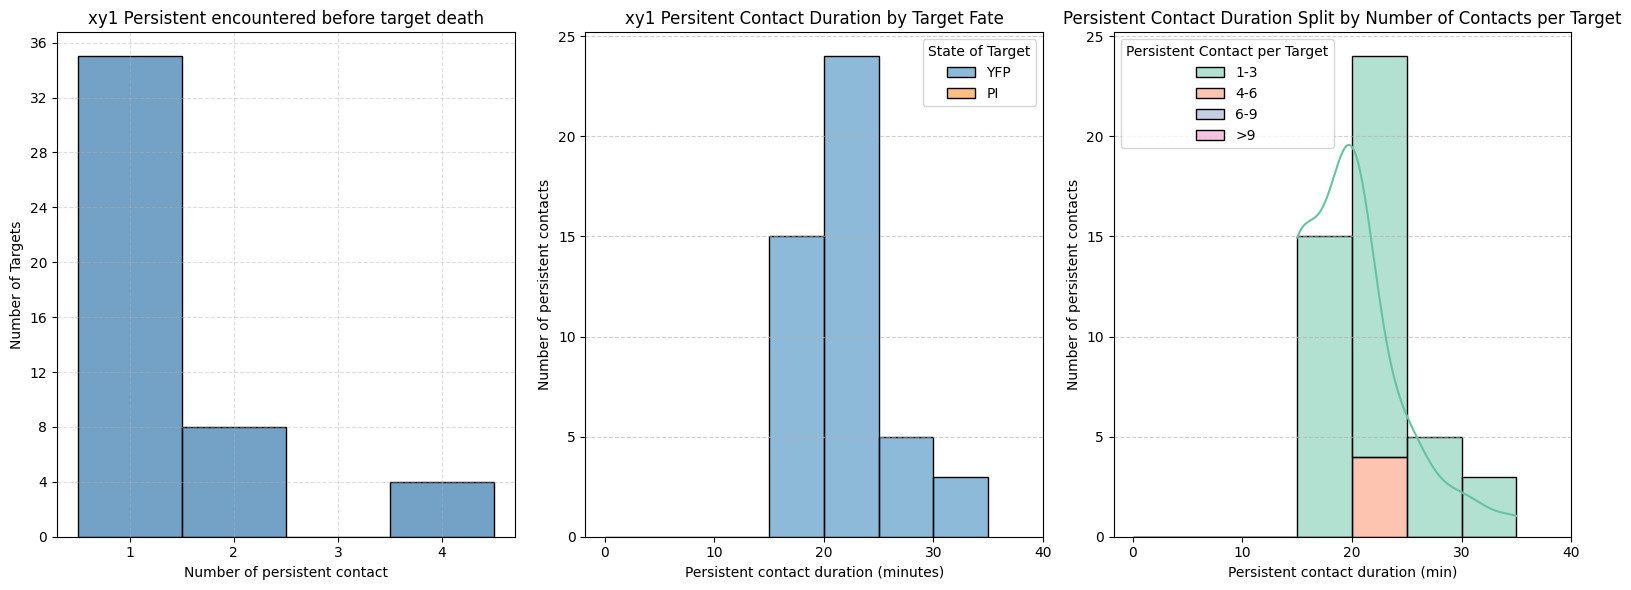

/tmp/ipykernel_22041/4102570193.py:148: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  persistent_df.groupby('target_ID')['Death_Frame']
/tmp/ipykernel_22041/4102570193.py:165: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max_rank + 1)


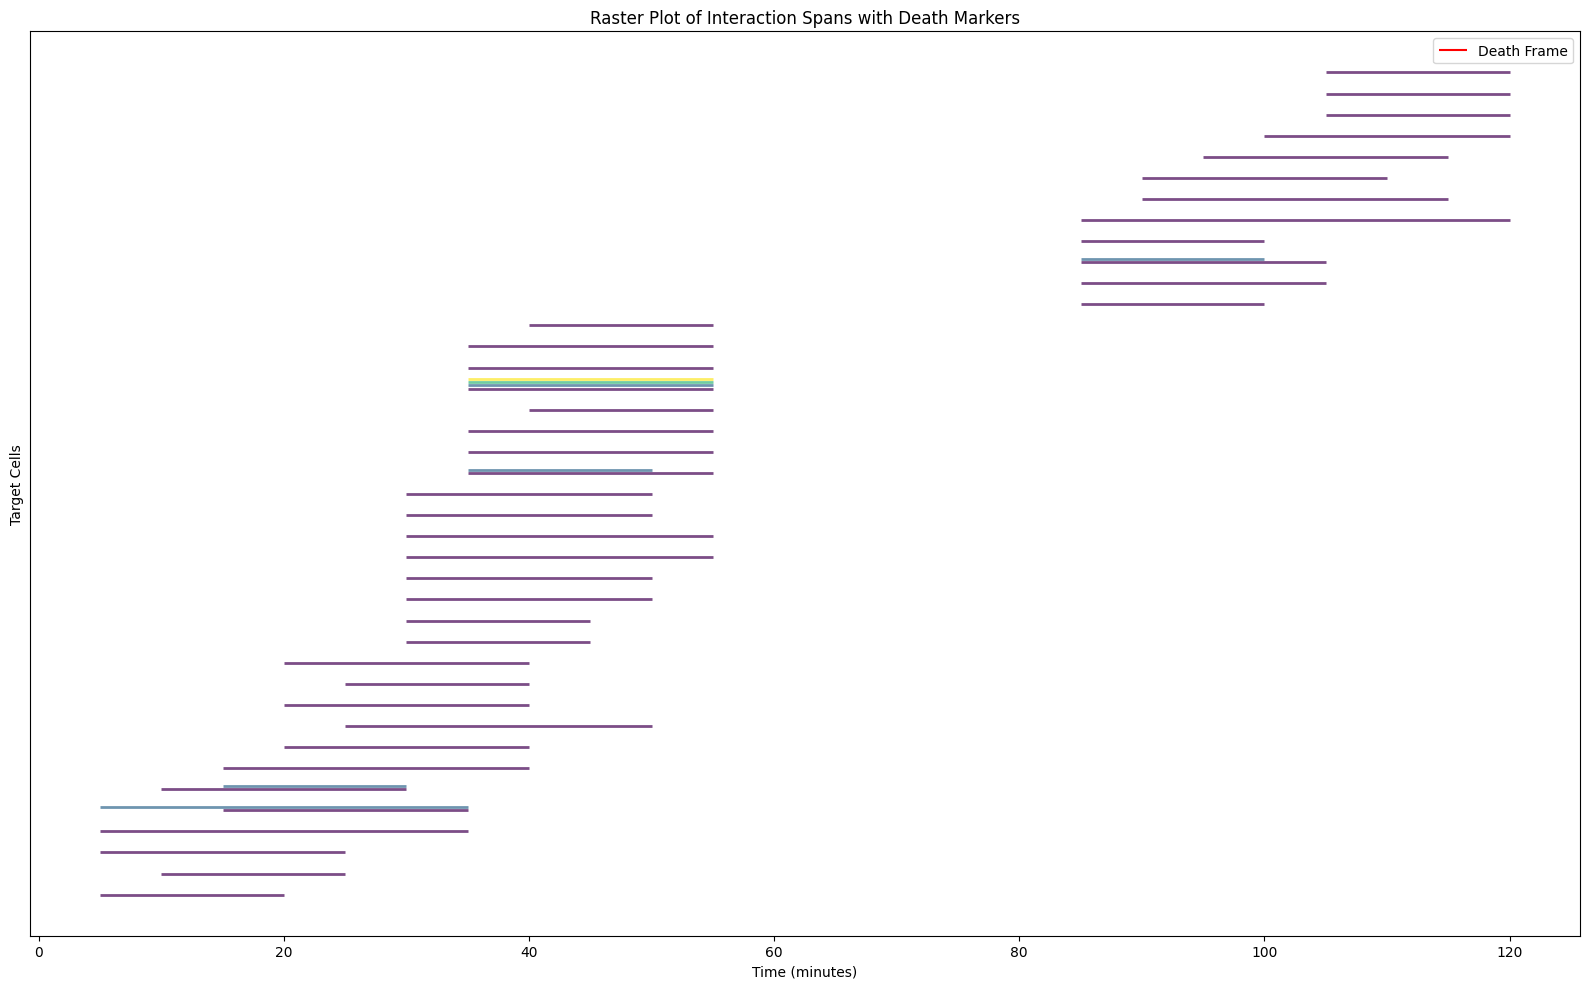

/tmp/ipykernel_22041/497626168.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transition_df = target_df.groupby('TRACK_ID', group_keys=False).apply(get_transition_frame).reset_index()


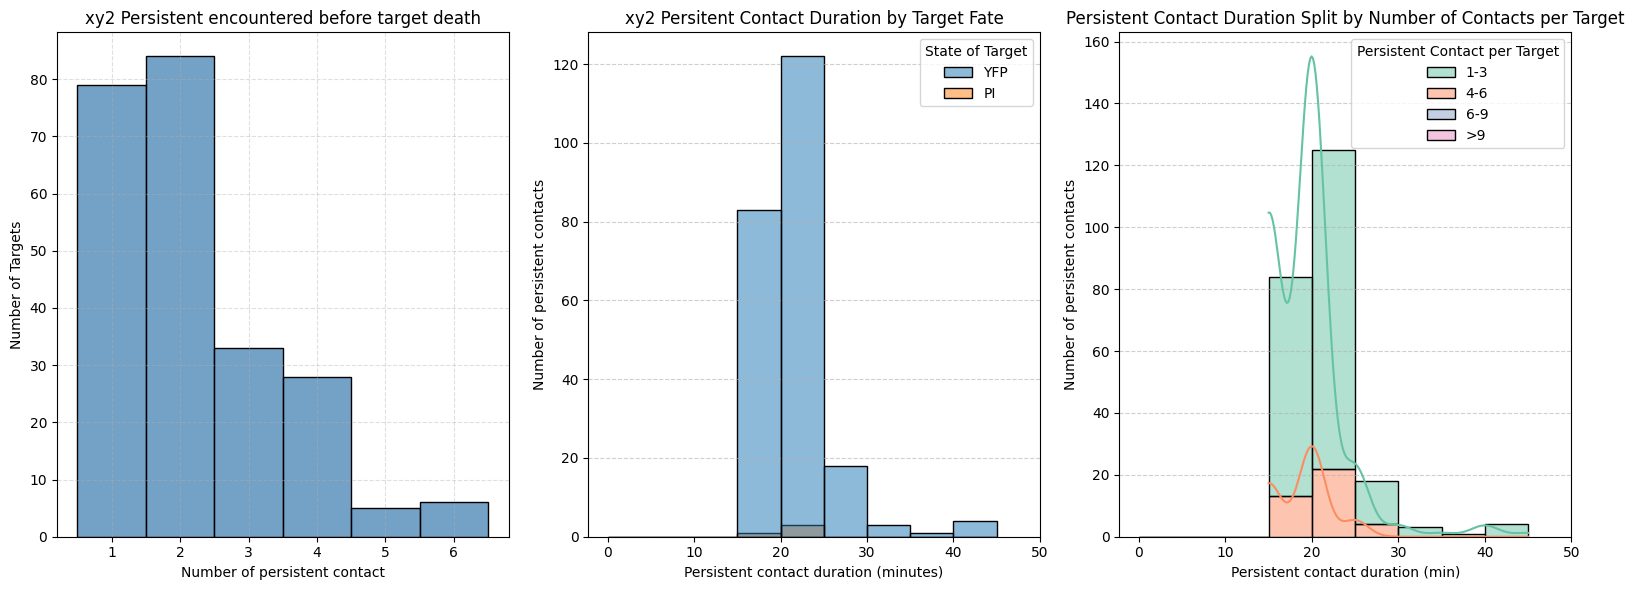

/tmp/ipykernel_22041/4102570193.py:148: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  persistent_df.groupby('target_ID')['Death_Frame']
/tmp/ipykernel_22041/4102570193.py:165: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max_rank + 1)


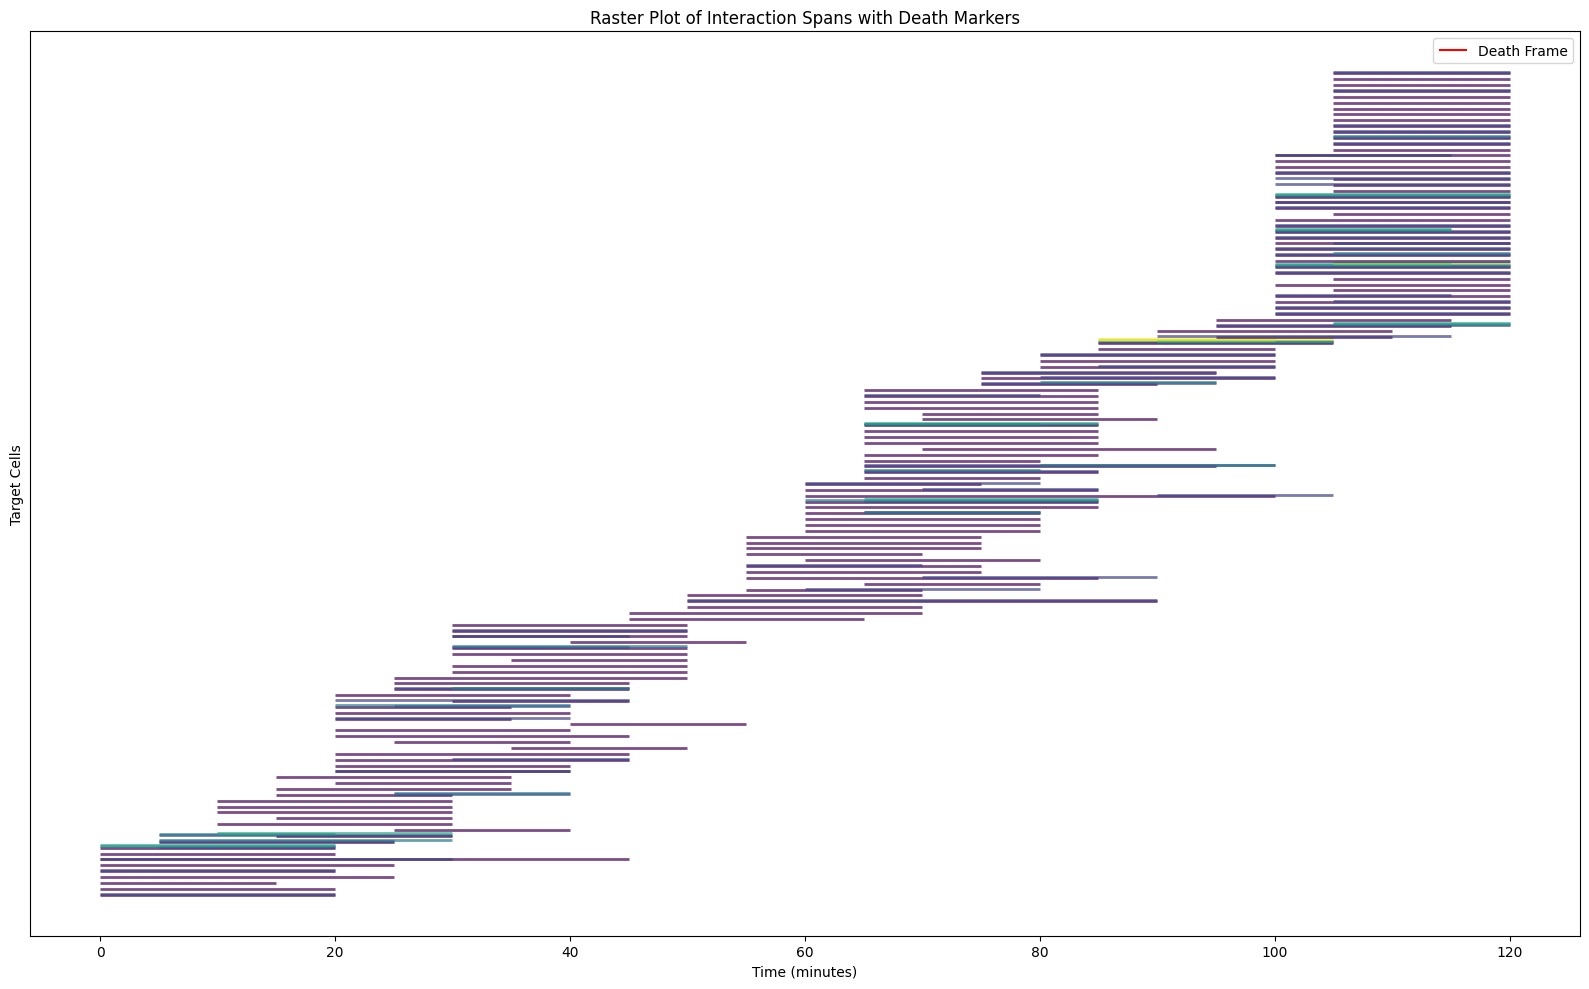

/tmp/ipykernel_22041/497626168.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transition_df = target_df.groupby('TRACK_ID', group_keys=False).apply(get_transition_frame).reset_index()


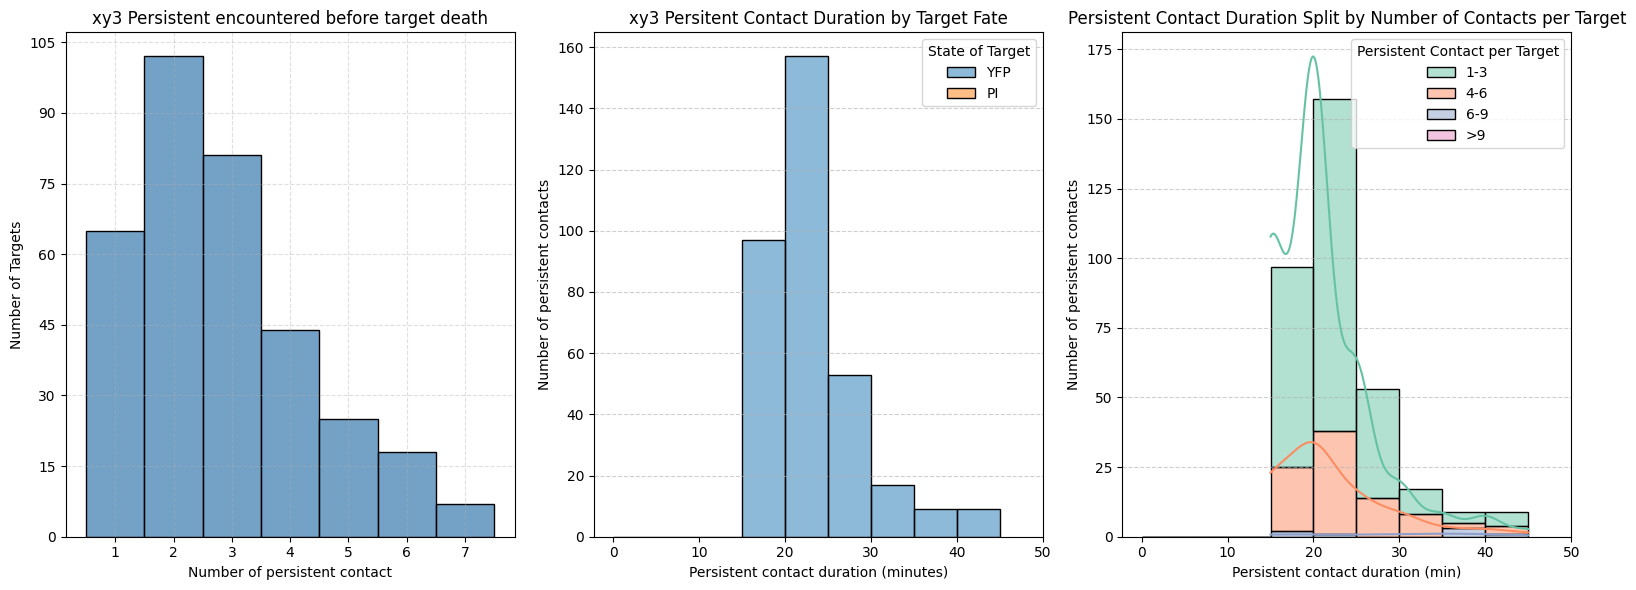

/tmp/ipykernel_22041/4102570193.py:148: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  persistent_df.groupby('target_ID')['Death_Frame']
/tmp/ipykernel_22041/4102570193.py:165: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max_rank + 1)


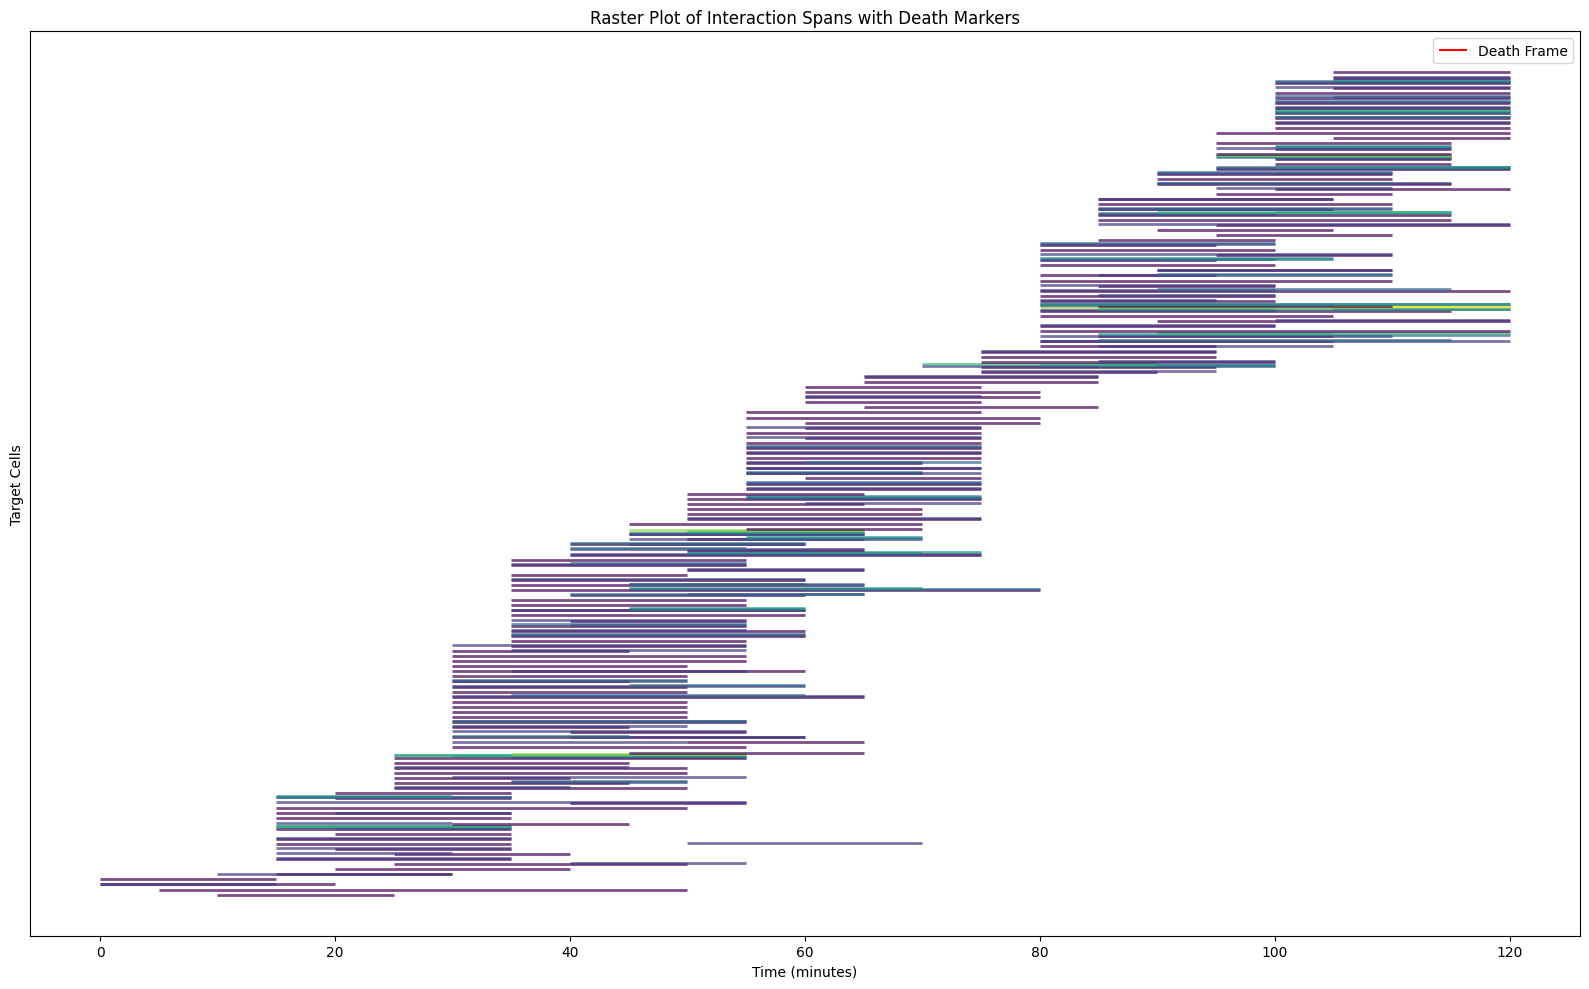

In [13]:
# Batch plot persistent encounter data
master_folder = '/home/vil945/live_cell_imaging/2025-03-26_live_cell_imaging'

# DO NOT change anything beyond this line
# Recursively go through subfolders within master_folder
for root, dirs, files in os.walk(master_folder):
    # Calculations from TrackMate data should be saved in folders that contain "tracking" in the name
    if "tracking" in root:
        path = Path(root)
        csv_files = list(path.glob("*.csv")) + list(path.glob("*/*.csv"))
    
        # Match pairs of target spots and  by matching index i within their file names "xy[i]_target", "xy[i]_effector"

        # Dictionaries: key = index i, value = file path
        target_files = {}
        persistent_files = {}

        for f in csv_files:
            target_match = re.search(r'xy(\d+)_target', f.name)
            persistent_match = re.search(r'xy(\d+)_persistent', f.name)
            if target_match:
                idx = target_match.group(1)
                target_files[idx] = f
            if persistent_match:
                idx = persistent_match.group(1)
                persistent_files[idx] = f

        matched_indices = sorted(set(target_files.keys()) & set(persistent_files.keys()))
    
        for i in matched_indices:
            target_file = target_files[i]
            persistent_file = persistent_files[i]

            # Load DataFrames
            target_df = pd.read_csv(target_file)
            persistent_df = pd.read_csv(persistent_file)
            
            # Pre-processing
            # Convert frame number to time
            frame_interval = 5
            persistent_df['Duration'] = (persistent_df['End_Frame'] - persistent_df['Start_Frame']) * frame_interval
            persistent_df['Start_Time'] = persistent_df['Start_Frame'] * frame_interval
            persistent_df['End_Time'] = persistent_df['End_Frame'] * frame_interval

            # Get terminal state (YFP or PI) of all targets
            all_targets = get_terminal_state(target_df, ['YFP', 'PI'])
            # Map terminal state into persistent interaction DataFrame
            id_to_state = all_targets.set_index("TRACK_ID")["TERMINAL_STATE"]
            persistent_df['Target_State'] = persistent_df['target_ID'].map(id_to_state)
            # Map transition frame into persistent interaction DataFrame
            id_to_transition = all_targets.set_index("TRACK_ID")["TRANSITION_FRAME"]
            persistent_df['Death_Frame'] = persistent_df['target_ID'].map(id_to_transition)
            persistent_df['Death_Time'] = persistent_df['Death_Frame'] * frame_interval
            
            # Count occurrences of all targets in persistent interaction DataFrame
            target_occurrences = count_occurrences(all_targets['TRACK_ID'], persistent_df)
            # Map number of occurrences into persistent interaction DataFrame
            id_to_count = target_occurrences.set_index("target_ID")["Occurrences"]
            # Assign the count to each row
            persistent_df['Interaction_Count'] = persistent_df['target_ID'].map(id_to_count)

            # Assign bins based on number of persistent contacts for each target
            bins = [0, 3, 6, 9, float('inf')]
            labels = ['1-3', '4-6', '6-9', '>9']
            persistent_df['Interaction_Group'] = pd.cut(persistent_df['Interaction_Count'], bins=bins, labels=labels)

            # Filter for dead cells only (plot dead cells only in histograms 1&3 and raster plot)
            dead_persistent_df = persistent_df[persistent_df['Target_State'] == 'PI']
            
            
            # Plot histograms
            fig, axes = plt.subplots(1, 3, figsize=(16, 6))
            # Plot 1
            # Manually set histogram bins and x-axis ticks
            max_target = max(persistent_df["Interaction_Count"].tolist())
            target_bins = np.arange(0.5, max_target + 1.5, 1)
            target_x_ticks = np.arange(1, max_target + 1)

            # Plot data
            sns.histplot(
                data=persistent_df, 
                x='Interaction_Count', 
                bins=target_bins, 
                color='steelblue', 
                ax=axes[0]
            )
            axes[0].set_title(f'xy{i} Persistent encountered before target death')
            axes[0].set_xlabel('Number of persistent contact')
            axes[0].set_ylabel('Number of Targets')
            axes[0].set_xticks(target_x_ticks)
            axes[0].yaxis.set_major_locator(MaxNLocator(integer=True)) # force y-axis ticks to be integers
            axes[0].grid(True, linestyle='--', alpha=0.4)

            # Plot 2
            # Manually set histogram bins and x-axis ticks
            plot2_max_duration = persistent_df['Duration'].max()
            plot2_bin_edges = np.arange(0, plot2_max_duration + 5, 5)

            # Plot data
            sns.histplot(
                data=persistent_df, 
                x="Duration", 
                hue="Target_State", 
                hue_order = ["YFP", "PI"],
                bins=plot2_bin_edges,
                palette = "tab10", 
                element = "bars", # "bars" or "step"
                ax=axes[1]
            )
            axes[1].set_title(f"xy{i} Persitent Contact Duration by Target Fate")
            axes[1].set_xlabel("Persistent contact duration (minutes)")
            axes[1].set_xticks(np.arange(0, plot2_max_duration + 10, 10))
            axes[1].set_ylabel("Number of persistent contacts")
            axes[1].grid(axis='y', linestyle='--', alpha=0.6)
            state_legend = axes[1].get_legend()
            state_legend.set_title('State of Target')

            # Plot 3
            # Manually set histogram bins and x-axis ticks
            plot3_max_duration = persistent_df['Duration'].max()
            plot3_bin_edges = np.arange(0, plot3_max_duration + 5, 5)
            
            sns.histplot(
                data=persistent_df,
                x="Duration",
                hue="Interaction_Group",
                bins=plot3_bin_edges,
                multiple="stack",  # "stack" or "dodge" or "layer"
                kde = True,
                palette="Set2",
                edgecolor="black",
                ax = axes[2]
            )
            axes[2].set_title("Persistent Contact Duration Split by Number of Contacts per Target")
            axes[2].set_xlabel("Persistent contact duration (min)")
            axes[2].set_xticks(np.arange(0, plot3_max_duration + 10, 10))
            axes[2].set_ylabel("Number of persistent contacts")
            axes[2].grid(axis='y', linestyle='--', alpha=0.6)
            interaction_legend = axes[2].get_legend()
            interaction_legend.set_title('Persistent Contact per Target')
        
            plt.tight_layout()
            plt.show()

            # Plot raster plot
            # Sort targets by death frame (or last frame if alive)
            target_order = (
                persistent_df.groupby('target_ID')['Death_Frame']
                .min()
                .fillna(1e9)
                .sort_values()
                .index
            )
            target_to_row = {tid: i for i, tid in enumerate(target_order)}
            persistent_df['Base_Row'] = persistent_df['target_ID'].map(target_to_row)

            # Assign interaction rank and vertical offset
            persistent_df['Interaction_Rank'] = persistent_df.groupby('target_ID').cumcount()
            persistent_df['Row'] = (
                persistent_df['Base_Row'] + persistent_df['Interaction_Rank'] * 0.15
            )
            
            # Normalize interaction rank to colormap range
            max_rank = persistent_df['Interaction_Rank'].max()
            cmap = cm.get_cmap('viridis', max_rank + 1)
            norm = mcolors.Normalize(vmin=0, vmax=max_rank)
            
            # Plotting interaction spans as horizontal lines
            plt.figure(figsize=(16, 10))
            
            for _, row in persistent_df.iterrows():
                color = cmap(norm(row['Interaction_Rank']))
                plt.hlines(
                    y=row['Row'],
                    xmin=row['Start_Time'],
                    xmax=row['End_Time'],
                    color=color,
                    linewidth=2,
                    alpha=0.7
                )
            
            # Plot death markers (vertical red lines)
            death_info = persistent_df.drop_duplicates('target_ID')[['target_ID', 'Death_Time', 'Base_Row']]
            death_info = death_info[~death_info['Death_Time'].isna()]
            
            plt.vlines(
                death_info['Death_Time'],
                death_info['Base_Row'] - 0.4,
                death_info['Base_Row'] + 0.4,
                color='red',
                linewidth=1.5,
                label='Death Frame'
            )
            
            # Plot styling
            plt.xlabel("Time (minutes)")
            plt.ylabel("Target Cells")
            plt.title("Raster Plot of Interaction Spans with Death Markers")
            plt.yticks([])  # Hide individual labels unless needed
            plt.legend()
            plt.tight_layout()
            plt.show()


In [14]:
print(dead_persistent_df.shape[0])

0
